In [1]:
import os
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from kan import *
### TORCH version of pykan env is 2.2.2; while for kgap env is 2.1.2

In [2]:
data_dir = "/home/carolina/Anansi/MA/KG/MNIST/data/logits_dataset/"
model_name = "Gonzalo_MLP4_SIGMOID"
logits = torch.load(os.path.join(data_dir, f"{model_name}__Xlogitsdata.pt"))
targets = torch.load(os.path.join(data_dir, f"{model_name}__Ylogitsdata.pt"))
logits.shape, targets.shape

(torch.Size([47309, 8]), torch.Size([47309, 8]))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(logits, targets, test_size=0.2, random_state=42)

In [4]:
dataset = {}
dataset['train_input'] = X_train
dataset['train_label'] = y_train
dataset['test_input'] = X_test
dataset['test_label'] = y_test

In [5]:
model = KAN(width=[10-2, 10-2], grid=10, k=3, seed=0, symbolic_enabled=True,
            base_fun=torch.nn.SiLU(),
            bias_trainable=True, sp_trainable=True, sb_trainable=True, LAN=False)
model

KAN(
  (biases): ModuleList(
    (0): Linear(in_features=8, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [6]:
total_params = 0
for name, param in model.named_parameters():
    print(name, param.shape)
    total_params += param.flatten().shape[0]
print(total_params)

biases.0.weight torch.Size([1, 8])
act_fun.0.grid torch.Size([64, 11])
act_fun.0.coef torch.Size([64, 13])
act_fun.0.scale_base torch.Size([64])
act_fun.0.scale_sp torch.Size([64])
act_fun.0.mask torch.Size([64])
symbolic_fun.0.mask torch.Size([8, 8])
symbolic_fun.0.affine torch.Size([8, 8, 4])
2056


In [8]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])).argmax(-1) == dataset['train_label'].argmax(-1)).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])).argmax(-1) == dataset['test_label'].argmax(-1)).float())

results = model.train(dataset, opt="LBFGS", steps=50, batch=-1, loss_fn=None, 
                      lamb=0.1, lamb_l1=0.01, lamb_entropy=0.5, update_grid=True,
                      grid_update_num=10, metrics=(train_acc, test_acc));
#results['train_acc'][-1], results['test_acc'][-1]

''' dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., 
lamb_coefdiff=0., update_grid=True, grid_update_num=10, loss_fn=None, lr=1., stop_grid_update_step=50, 
batch=-1, small_mag_threshold=1e-16, small_reg_factor=1., metrics=None, sglr_avoid=False, 
save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', device='cpu')


steps = training_steps = epochs * num_batches = epochs * rpund_up(train_dataset.size()/num_batches)
'''

train loss: 1.60e-01 | test loss: 1.60e-01 | reg: 1.52e+00 : 100%|██| 50/50 [18:26<00:00, 22.14s/it]


' dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., \nlamb_coefdiff=0., update_grid=True, grid_update_num=10, loss_fn=None, lr=1., stop_grid_update_step=50, \nbatch=-1, small_mag_threshold=1e-16, small_reg_factor=1., metrics=None, sglr_avoid=False, \nsave_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder=\'./video\', device=\'cpu\')\n\n\nsteps = training_steps = epochs * num_batches = epochs * rpund_up(train_dataset.size()/num_batches)\n'

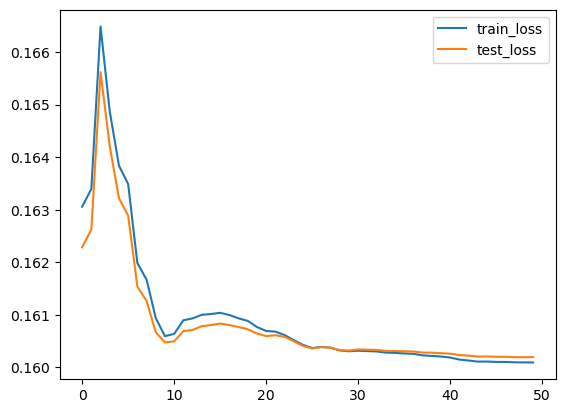

In [9]:
plt.plot(results["train_loss"], label="train_loss")
plt.plot(results["test_loss"], label="test_loss")
plt.legend()

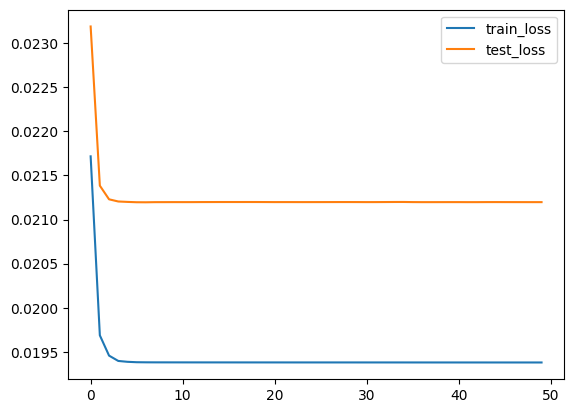

In [8]:
plt.plot(np.arange(50), results["train_loss"], label="train_loss")
plt.plot(np.arange(50), results["test_loss"], label="test_loss")
plt.legend()

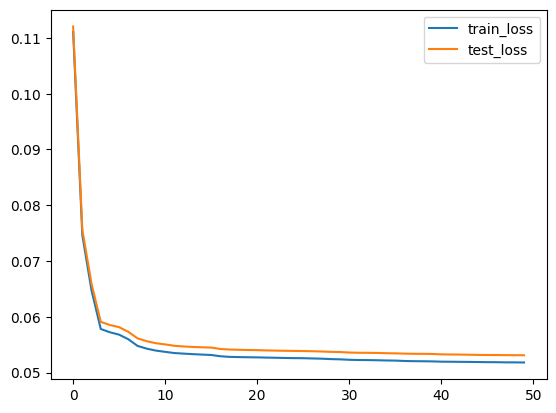

In [8]:
plt.plot(np.arange(50), results["train_loss"], label="train_loss")
plt.plot(np.arange(50), results["test_loss"], label="test_loss")
plt.legend()

In [16]:
results['train_acc'][-1], results['test_acc'][-1]

(0.837847113609314, 0.8321707844734192)

In [10]:
model.save_ckpt('ckpt1_kgap')
# model.load_ckpt('ckpt1')
#model(dataset['train_input'])

save this model to ./model_ckpt/ckpt1_kgap


In [11]:
model.plot(beta=7, mode="unsupervised", scale=2, tick=True, plot_full=False)

In [10]:
x_min = torch.tensor(-288.4102, dtype=torch.float64)
x_max = torch.tensor(-288.4102, dtype=torch.float64) 
['%4.4f' % x_min, '%4.4f' % x_max]

['-288.4102', '-288.4102']

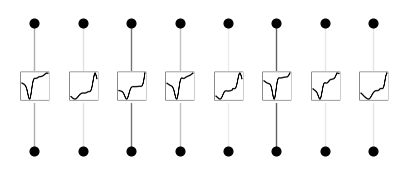

In [18]:
model.plot_LAN(beta=7, mode="supervised")

In [27]:
score = model.acts_scale_std[0]
[torch.tanh(s) for s in score]

[tensor([3.1816e-01, 6.9964e-07, 3.1733e-01, 3.2039e-01, 3.1238e-01, 2.9873e-01,
         3.1378e-01, 3.1958e-01, 3.1113e-01, 6.8173e-07], dtype=torch.float64,
        grad_fn=<TanhBackward0>)]

In [31]:
[torch.tanh(7*s) for s in score]

[tensor([9.8038e-01, 4.8975e-06, 9.8013e-01, 9.8104e-01, 9.7855e-01, 9.7359e-01,
         9.7901e-01, 9.8080e-01, 9.7814e-01, 4.7721e-06], dtype=torch.float64,
        grad_fn=<TanhBackward0>)]

In [12]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=["exp"]) #lib=lib
formula = model.symbolic_formula()[0]
formula

fixing (0,0,0) with exp, r2=0.6009299647496662
fixing (0,0,1) with exp, r2=0.8054752674960355
fixing (0,0,2) with exp, r2=0.1515582333484139
fixing (0,0,3) with exp, r2=0.8013819493348137
fixing (0,0,4) with exp, r2=0.2482038512154087
fixing (0,0,5) with exp, r2=0.7348923089093724
fixing (0,0,6) with exp, r2=0.20296113408204064
fixing (0,0,7) with exp, r2=0.4656076672636168
fixing (0,1,0) with exp, r2=0.21547408735228607
fixing (0,1,1) with exp, r2=0.5612332836365639
fixing (0,1,2) with exp, r2=0.49001707912782283
fixing (0,1,3) with exp, r2=0.4293546963631097
fixing (0,1,4) with exp, r2=0.7792217574309388
fixing (0,1,5) with exp, r2=0.7864225934482834
fixing (0,1,6) with exp, r2=0.7872775034079585
fixing (0,1,7) with exp, r2=0.782176260281863
fixing (0,2,0) with exp, r2=0.4294942790365407
fixing (0,2,1) with exp, r2=0.7738029649783837
fixing (0,2,2) with exp, r2=0.49669941707411597
fixing (0,2,3) with exp, r2=0.31958127861991964
fixing (0,2,4) with exp, r2=0.774376754280099
fixing (0,

[x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8]

In [16]:
model.LAN

False

In [14]:
formula = model.symbolic_formula()

In [12]:
l=0
for i in range(10):
    j=0
    symbol_mask = model.symbolic_fun[l].mask[j][i]
    numerical_mask = model.act_fun[l].mask.reshape(1, model.width[l])[j][i]
    if symbol_mask != 0:
        print(symbol_mask)
    if numerical_mask != 1:
        print(numerical_mask)

In [11]:
l=0
i=0
j=0
rank = torch.argsort(model.acts[l][:, i])
model.acts[l][:, i][rank] #x in plot sp_l_i_j; each value of x corresponds to the input (dim=i) values for layer l

tensor([-215.3589, -198.7613, -187.4117,  ...,  113.8791,  115.5762,
         133.5972], dtype=torch.float64)

In [12]:
model.spline_postacts[l][:, j, i][rank] #y; each value of y corresponds to a batch image/sample's
#pos_spline values (batch, in_neurons, out_neurons) of layer l

tensor([4.5884e-02, 1.0971e-01, 1.8204e-01,  ..., 2.4570e+01, 2.6622e+01,
        4.8890e+01], dtype=torch.float64)

In [24]:
l, i, j = 0, 0, 0
len(model.acts[l][:, :]), model.acts[l][0, :].shape, model.acts[l][0, :]
#model.spline_postacts[l][:, j, i]

(100,
 torch.Size([784]),
 tensor([-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
  

In [24]:
del model

How do they increase number of grid points during training?
*   at each n step, they just reinitialize the model with this method: initialize_from_another_model?